In [1]:
import numpy as np
import matplotlib.pyplot as plt

# بارگزاری داده ها
from data_utils import load_CIFAR10
cifar10_dir = 'ds/cifar-10-batches-py'
# انتصاب داده های تست و ترین
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [2]:
# # Visualize some examples from the dataset.
# # We show a few examples of training images from each class.
# classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# num_classes = len(classes)
# samples_per_class = 7
# for y, cls in enumerate(classes):
#     idxs = np.flatnonzero(y_train == y)
#     idxs = np.random.choice(idxs, samples_per_class, replace=False)
#     for i, idx in enumerate(idxs):
#         plt_idx = i * num_classes + y + 1
#         plt.subplot(samples_per_class, num_classes, plt_idx)
#         plt.imshow(X_train[idx].astype('uint8'))
#         plt.axis('off')
#         if i == 0:
#             plt.title(cls)
# plt.show()

In [3]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [4]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


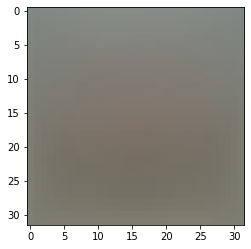

In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [6]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val   -= mean_image
X_test  -= mean_image
X_dev   -= mean_image

In [7]:
# create W and b randomly with small numbers
N = X_train.shape[0]           # number of training data
D = np.prod(X_train.shape[1:]) # number of features
C = 10                         # number of classes

# init parameters
W = 0.0001 * np.random.randn(D, C)
b = np.zeros((C,))

In [8]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.
    Inputs:
        - dout: Upstream derivative, of shape (N, C)
        - cache: Tuple of:
            - x: Input data, of shape (N, d_1, ... d_k)
            - w: Weights, of shape (D, C)
            - b: biases, of shape (C,)
    Outputs:
        - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
        - dw: Gradient with respect to w, of shape (D, C)
        - db: Gradient with respect to b, of shape (C,)
    """
    x, w, b = cache
    x2d = np.reshape(x, (x.shape[0], -1))

    # compute gradients
    db = np.sum(dout, axis=0)
    dw = np.dot(x2d.T, dout)
    dx = np.dot(dout, w.T)

    # reshape dx to match the size of x
    dx = dx.reshape(x.shape)
    
    return dx, dw, db

In [9]:
def affine_forward(x, W, b):
    """
    A linear mapping from inputs to scores.
    
    Inputs:
        - x: input matrix (N, d_1, ..., d_k)
        - W: weigh matrix (D, C)
        - b: bias vector  (C, )
    
    Outputs:
        - out: output of linear layer (N, C)
    """
    x2d = np.reshape(x, (x.shape[0], -1))  # convert 4D input matrix to 2D    
    out = np.dot(x2d, W) + b               # linear transformation
    cache = (x, W, b)                      # keep for backward step (stay with us)
    return out, cache

In [10]:
def softmax_loss(s, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - s: Input data, of shape (N, C) where s[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    
    # forward step: computing data loss
    shifted_logits = s - np.max(s, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = s.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    
    # backward step: computing gradient of loss w.r.t. s (scores).
    ds = probs.copy()
    ds[np.arange(N), y] -= 1
    ds /= N
    return loss, ds

In [11]:
def svm_loss(s, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - s: Input data, of shape (N, C) where s[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    
    # forward step: computing data loss
    N = s.shape[0]
    correct_class_scores = s[np.arange(N), y]
    margins = np.maximum(0, s - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    
    # backward step: computing gradient of loss w.r.t. s (scores).
    num_pos = np.sum(margins > 0, axis=1)
    ds = np.zeros_like(s)
    ds[margins > 0] = 1
    ds[np.arange(N), y] -= num_pos
    ds /= N
    return loss, ds

In [15]:
N = X_train.shape[0]

# define parameters for mini-batch GD
num_iterations =2000 #1500
batch_size = 512#256
learning_rate = 1e-7
reg = 2.5e4#2.5e5

# initialize weights
W = 0.0001 * np.random.randn(3072, 10)
b = np.zeros(10)

loss_history = []

for i in range(num_iterations + 1):
    # create a batch of data
    batch_idxs = np.random.choice(N, batch_size, replace=False)
    X_batch = X_train[batch_idxs]
    y_batch = y_train[batch_idxs]
    
    # forward step
    scores, cache = affine_forward(X_batch, W, b)
    
    # compute loss
    loss, dscores = softmax_loss(scores, y_batch)  # data loss
#     loss, dscores = svm_loss(scores, y_batch)  # data loss
    loss += 0.5 * reg * np.sum(W * W)          # regularization loss
    loss_history.append(loss)
    
    # backward step
    _, dW, db = affine_backward(dscores, cache)
    dW += reg * W
      
    # report every 100 iteration
    if i % 100 == 0:
        y_preds = np.argmax(scores, axis=1)
        train_accuracy = 100.0 * np.mean(y_preds == y_batch)
        
        val_scores, _ = affine_forward(X_val, W, b)
        val_preds = np.argmax(val_scores, axis=1)
        val_accuracy = 100.0 * np.mean(val_preds == y_val)
        print("Iteration %4d: loss = %5.2f | train accuracy = %5.2f | validation accuracy = %5.2f" % 
             (i, loss, train_accuracy, val_accuracy))
    
    # update rule
    W = W - learning_rate * dW
    b = b - learning_rate * db

Iteration    0: loss =  6.24 | train accuracy =  8.01 | validation accuracy =  8.70
Iteration  100: loss =  4.42 | train accuracy = 27.15 | validation accuracy = 29.50
Iteration  200: loss =  3.42 | train accuracy = 32.62 | validation accuracy = 32.10
Iteration  300: loss =  2.86 | train accuracy = 30.47 | validation accuracy = 34.20
Iteration  400: loss =  2.55 | train accuracy = 35.55 | validation accuracy = 35.10
Iteration  500: loss =  2.35 | train accuracy = 34.57 | validation accuracy = 35.70
Iteration  600: loss =  2.25 | train accuracy = 34.18 | validation accuracy = 35.50
Iteration  700: loss =  2.14 | train accuracy = 33.98 | validation accuracy = 36.40
Iteration  800: loss =  2.08 | train accuracy = 36.72 | validation accuracy = 36.10
Iteration  900: loss =  2.07 | train accuracy = 35.74 | validation accuracy = 36.40
Iteration 1000: loss =  2.05 | train accuracy = 32.81 | validation accuracy = 36.00
Iteration 1100: loss =  1.99 | train accuracy = 36.91 | validation accuracy 

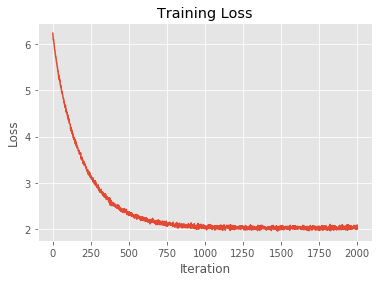

In [16]:
plt.style.use('ggplot')

plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss');